In [1]:
from imports import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import data_management
from data_management import load_stack
from data_management import load_data

import interactive_plot

import metrics
from metrics import statistics
from metrics import confusion_matrix
from metrics import error_distribution
from metrics import error_borders
from metrics import PR_curve

import generator_extended

import unet
from unet import load_model_unet
from unet import predict_net
from unet import get_unet
from unet import train
from unet import execute_predict

### Load data

In [4]:
#training
imgs_train, imgs_mask_train = load_data(['/home/daniel_haehn/Lucchi++/Train_In'], 
                                        ['/home/daniel_haehn/Lucchi++/Train_Out'])

  0%|          | 0/1 [00:00<?, ?it/s]

found 165 images in /home/daniel_haehn/Lucchi++/Train_In
found 165 in total.


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

(165, 768, 1024, 1)
(165, 768, 1024, 1)


In [5]:
#testing
imgs_test, imgs_mask_test = load_data(['/home/daniel_haehn/Lucchi++/Test_In'], 
                                      ['/home/daniel_haehn/Lucchi++/Test_Out'])

  0%|          | 0/1 [00:00<?, ?it/s]

found 165 images in /home/daniel_haehn/Lucchi++/Test_In
found 165 in total.


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

(165, 768, 1024, 1)
(165, 768, 1024, 1)


In [6]:
print(imgs_train.min(), imgs_train.max())
print(imgs_mask_train.min(), imgs_mask_train.max())
print(imgs_test.min(), imgs_test.max())
print(imgs_mask_test.min(), imgs_mask_test.max())

0.08627451 0.95686275
0.0 1.0
0.007843138 1.0
0.0 1.0


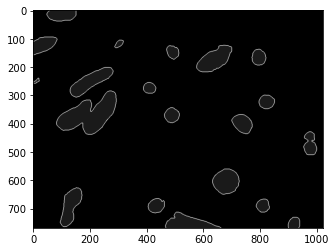

In [7]:
plt.figure(figsize=(7,4))
plt.imshow(imgs_mask_test[0,:,:,0], cmap='gray')
bimg = mh.borders(imgs_mask_test[0,:,:,0]).astype(int)
res = plt.imshow(bimg, alpha=0.9, cmap='gray')

### Run Training

In [8]:
model = get_unet(0.0005, 512, 512, dr_rate=0.2, diceloss=False, jaccardloss=False, 
                 focalloss=False, customloss=False, start_filters=16)

start_filters 16
conv1 shape: (None, 512, 512, 16)
conv1 shape: (None, 512, 512, 16)
pool1 shape: (None, 256, 256, 16)
conv2 shape: (None, 256, 256, 32)
conv2 shape: (None, 256, 256, 32)
pool2 shape: (None, 128, 128, 32)
conv3 shape: (None, 128, 128, 64)
conv3 shape: (None, 128, 128, 64)
pool3 shape: (None, 64, 64, 64)


In [10]:
#model = load_model_unet('/home/daniel_haehn/mitochondria/a-fully-supervised-unet/models/lucchi-pp/weights.675-0.02.hdf5', 
#                         use_dice_loss=False, use_jaccard_loss=False, use_focal_loss=False)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
train(model, imgs_train, imgs_mask_train, imgs_test, imgs_mask_test,
      'models/A100test', 4, 1000, verbosity=1, 
      perform_flipping=True, perform_rotation=True, to_dir=False, train_on_borders=False)


-------------------------------
data details:
imgs_train.shape (165, 768, 1024, 1)
imgs_mask_train.shape (165, 768, 1024, 1)
imgs_test.shape (165, 768, 1024, 1)
imgs_mask_test.shape (165, 768, 1024, 1)
imgs_train.dtype float32
imgs_mask_train.dtype float32
imgs_test.dtype float32
imgs_mask_test.dtype float32
balance:
train_total_px 129761280
train_labeled_positive 9077301
train_fraction_positive 0.06995384909889915
min, max train 0.08627451 0.95686275
train_total_px 129761280 number 0/1 in mask 129761280
test_total_px 129761280
test_labeled_positive 8676885
test_fraction_positive 0.0668680595629143
min, max test 0.007843138 1.0
loading data done
saving model checkpoints in models/A100test/
saving logfile in  models/A100test/log.txt
augmenting on the fly...
computing statistics...
<generator object train.<locals>.combine_generator at 0x7f9b5074e510>
Instructions for updating:
Please use Model.fit, which supports generators.
starting...
Epoch 1/1000


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at /home/daniel_haehn/mitochondria/a-fully-supervised-unet/unet.py:169) ]] [Op:__inference_train_function_3291]

Function call stack:
train_function


### Evaluate

In [ ]:
pred = execute_predict(model, imgs_test, stepsize=512, resize_shortest=True, extensive=False)

In [ ]:
np.save('predictions.npy', pred)

In [ ]:
cmatrix = confusion_matrix(pred, imgs_mask_test)

In [ ]:
statistics(cmatrix)

In [ ]:
error_distribution(model, imgs_test, imgs_mask_test, extensive=True, figsize=(15,10))

In [ ]:
PR_curve(pred, imgs_mask_test)

### Results On Single Image

In [ ]:
use_train = False
imgnr = 60
input_img = cv2.imread('/n/regal/pfister_lab/vincent/vcasser/connectomics/movements/epfl-' + ('train' if use_train else 'test') + '-crop/' + str(imgnr) + '.png',0) 
gt = misc.imread('/n/regal/pfister_lab/vincent/vcasser/connectomics/movements/epfl-' + ('train' if use_train else 'test') + '-crop-mask/' + str(imgnr) + '.png')
print(gt.shape)

plt.figure(figsize = (15,15))
plt.imshow(input_img, cmap='gray')

print(input_img.shape)
res = execute_predict(model, input_img.reshape(1,512,512,1).astype(float)/255.)
print(res.min(), res.max())

res[res>0.5]=1
res[res<=0.5]=0

plt.figure(figsize = (15,15))
plt.imshow(res[0,:,:,0], cmap='gray')

plt.figure(figsize = (15,15))
plt.imshow(gt[:,:,0], cmap='gray')

cv2.imwrite('example_img_gt.png', gt)
cv2.imwrite('example_img_raw.png', input_img)
cv2.imwrite('example_img.png', res[0,:,:,0]*255.)

### Server

In [ ]:
import socket 
import io
from scipy import misc
import matplotlib.pyplot as plt
from scipy.misc import toimage
%matplotlib inline

def run(TCP_IP, TCP_PORT, BUFFER_SIZE=32768):
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s.bind((TCP_IP, TCP_PORT))
    
    s.listen(1)
  
    while(True):
        try:
            print('waiting for incoming connections...')
            conn, addr = s.accept()
            print('Connection address:', addr)
            while(True):
                req = conn.recv(BUFFER_SIZE)
                if not req: break
                if len(req)<=1: continue #ignore tests if alive

                length = int(req.decode("utf-8"))
                ct=0
                b = io.BytesIO()

                while(ct<length):
                    req = conn.recv(min(BUFFER_SIZE, length-ct))
                    b.write(req)
                    ct+=len(req)
                b.seek(0)
                img = misc.imread(b)[:,:,0] #buff)

                handle_request(req,conn,img)

        except:
            
            print('connection closed.')
            conn.close()
            
def handle_request(req, conn, img):
    img = img/255.0
    img = img.reshape(1,img.shape[0], img.shape[1], 1)
    result = execute_predict(img)
    result = result[0,:,:,0]
    
    result[result<0.5]=0
    result[result>=0.5]=1
    newres = np.zeros(shape=(result.shape[0], result.shape[1],4))
    newres[:,:,0]=result
    newres[:,:,1]=0
    newres[:,:,2]=0
    newres[:,:,3]=result/4
    
    result = newres
    
    resultb = io.BytesIO()
    misc.imsave(resultb, result, format='png')
    resultb.seek(0)
    buff = resultb.read()
    
    conn.send(str.encode(str(len(buff))))
    conn.send(buff)

In [ ]:
run('127.0.0.1', 9875)